In [1]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
network_csv = pd.read_csv('/Users/mandarmp/Documents/CDKL5Paper/Fig4/CDKL5_E6T1_Jun2025_jun26/Network_outputs/Compiled_Networks.csv')

In [5]:
network_csv.columns

Index(['Run_ID', 'DIV', 'Assay', 'Well', 'NeuronType', 'Time', 'Chip_ID',
       'mean_IBI', 'cov_IBI', 'mean_Burst_Peak', 'cov_Burst_Peak',
       'Number_Bursts', 'burstRate', 'mean_Spike_per_Burst',
       'cov_Spike_per_Burst', 'mean_Burst_Peak_Abs', 'cov_Burst_Peak_Abs',
       'mean_BurstDuration', 'cov_BurstDuration', 'BaselineFiringRate',
       'IBI_List', 'Burst_Peak_List', 'Abs_Burst_Peak_List',
       'Burst_Times_List', 'SpikesPerBurst_List', 'LogISI_NumBursts',
       'LogISI_MeanBurstDur', 'LogISI_CV_BurstDur', 'LogISI_MeanSpikes',
       'LogISI_CV_Spikes', 'LogISI_MeanIBI', 'LogISI_CV_IBI',
       'LogISI_BurstIBIList', 'LogISI_BurstPeaks', 'LogISI_BurstDuration'],
      dtype='object')

In [14]:
burst_times = [float(x) for x in network_csv['Burst_Times_List'][0].split(',')]
# Efficiently convert 'Burst_Times_List' column to lists of floats for all rows
network_csv['Burst_Times_List_Numeric'] = network_csv['Burst_Times_List'].apply(lambda x: [float(i) for i in str(x).split(',')])


In [15]:
network_csv.columns

Index(['Run_ID', 'DIV', 'Assay', 'Well', 'NeuronType', 'Time', 'Chip_ID',
       'mean_IBI', 'cov_IBI', 'mean_Burst_Peak', 'cov_Burst_Peak',
       'Number_Bursts', 'burstRate', 'mean_Spike_per_Burst',
       'cov_Spike_per_Burst', 'mean_Burst_Peak_Abs', 'cov_Burst_Peak_Abs',
       'mean_BurstDuration', 'cov_BurstDuration', 'BaselineFiringRate',
       'IBI_List', 'Burst_Peak_List', 'Abs_Burst_Peak_List',
       'Burst_Times_List', 'SpikesPerBurst_List', 'LogISI_NumBursts',
       'LogISI_MeanBurstDur', 'LogISI_CV_BurstDur', 'LogISI_MeanSpikes',
       'LogISI_CV_Spikes', 'LogISI_MeanIBI', 'LogISI_CV_IBI',
       'LogISI_BurstIBIList', 'LogISI_BurstPeaks', 'LogISI_BurstDuration',
       'Burst_Times_List_Numeric'],
      dtype='object')

/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1162330898.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/Users/mandarmp/anaconda3/envs/map/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1162330898.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1162330898.py:44: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(
/var/folders/6w/yr2wjnw

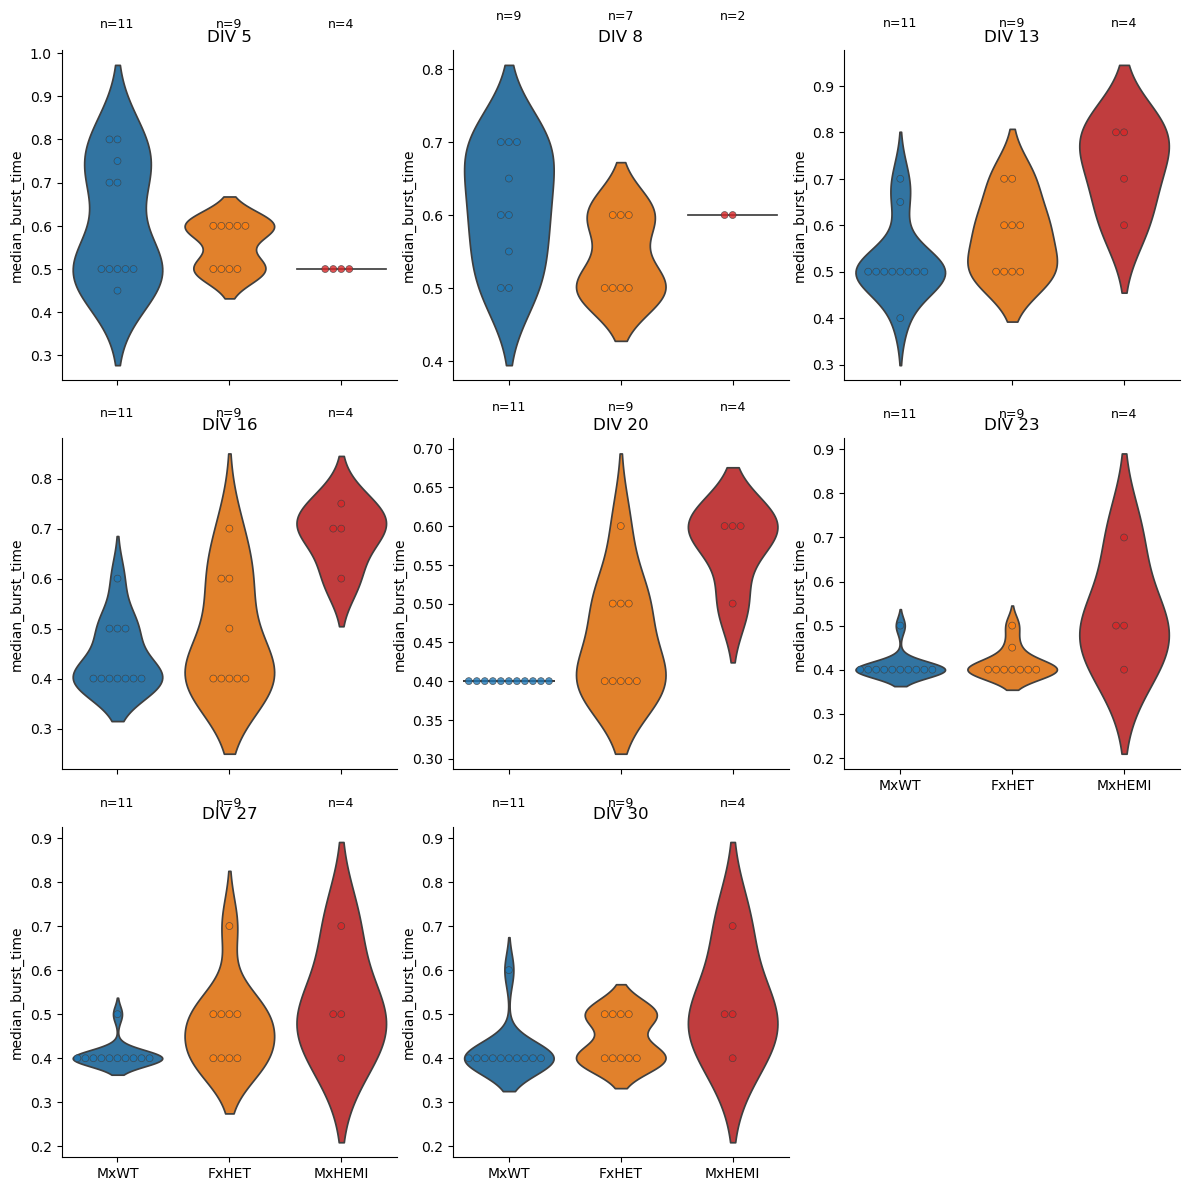

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Prepare long form (one row per burst time) ---
long_df = network_csv[['DIV', 'Well', 'Chip_ID', 'NeuronType', 'Burst_Times_List_Numeric']].copy()
long_df = long_df.rename(columns={'Burst_Times_List_Numeric': 'Burst_Time_List'})
long_df['ChipID_Well'] = long_df['Chip_ID'].astype(str) + '_W' + long_df['Well'].astype(str)

# explode lists -> one row per burst time
long_df = long_df.explode('Burst_Time_List').reset_index(drop=True)
long_df = long_df.rename(columns={'Burst_Time_List': 'Burst_Time'})
long_df['Burst_Time'] = pd.to_numeric(long_df['Burst_Time'], errors='coerce')
long_df = long_df.dropna(subset=['Burst_Time'])

# --- Aggregate burst times per ChipID_Well ---
agg_df = long_df.groupby(['DIV', 'ChipID_Well', 'NeuronType']).agg(
    median_burst_time=('Burst_Time', 'median')
).reset_index()

# optional: set plotting order and palette (adjust to your categories)
order = ['MxWT', 'FxHET', 'MxHEMI']
palette = {'MxWT': '#1f77b4', 'FxHET': '#ff7f0e', 'MxHEMI': '#d62728'}

# --- Faceted violin per DIV grouped by NeuronType on per-well median burst time ---
g = sns.catplot(
    data=agg_df,
    x='NeuronType',
    y='median_burst_time',
    col='DIV',
    kind='violin',
    order=order,
    palette=palette,
    col_wrap=3,
    height=4,
    sharey=False,
    inner=None
)

# Overlay swarmplot with individual medians
for ax, div in zip(g.axes.flat, sorted(agg_df['DIV'].unique())):
    sub = agg_df[agg_df['DIV'] == div]
    sns.swarmplot(
        data=sub,
        x='NeuronType',
        y='median_burst_time',
        order=order,
        palette=palette,
        size=5,
        edgecolor='gray',
        linewidth=0.5,
        alpha=0.8,
        ax=ax
    )
    # Annotate n (number of ChipID_Well per NeuronType)
    counts = sub.groupby('NeuronType')['ChipID_Well'].nunique()
    for i, nt in enumerate(order):
        n = counts.get(nt, 0)
        ax.text(i, ax.get_ylim()[1] * 1.05, f'n={n}', ha='center', fontsize=9)
    ax.set_title(f'DIV {div}')
    ax.set_xlabel('')



/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/537442289.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/537442289.py:51: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/537442289.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/537442289.py:51: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.s

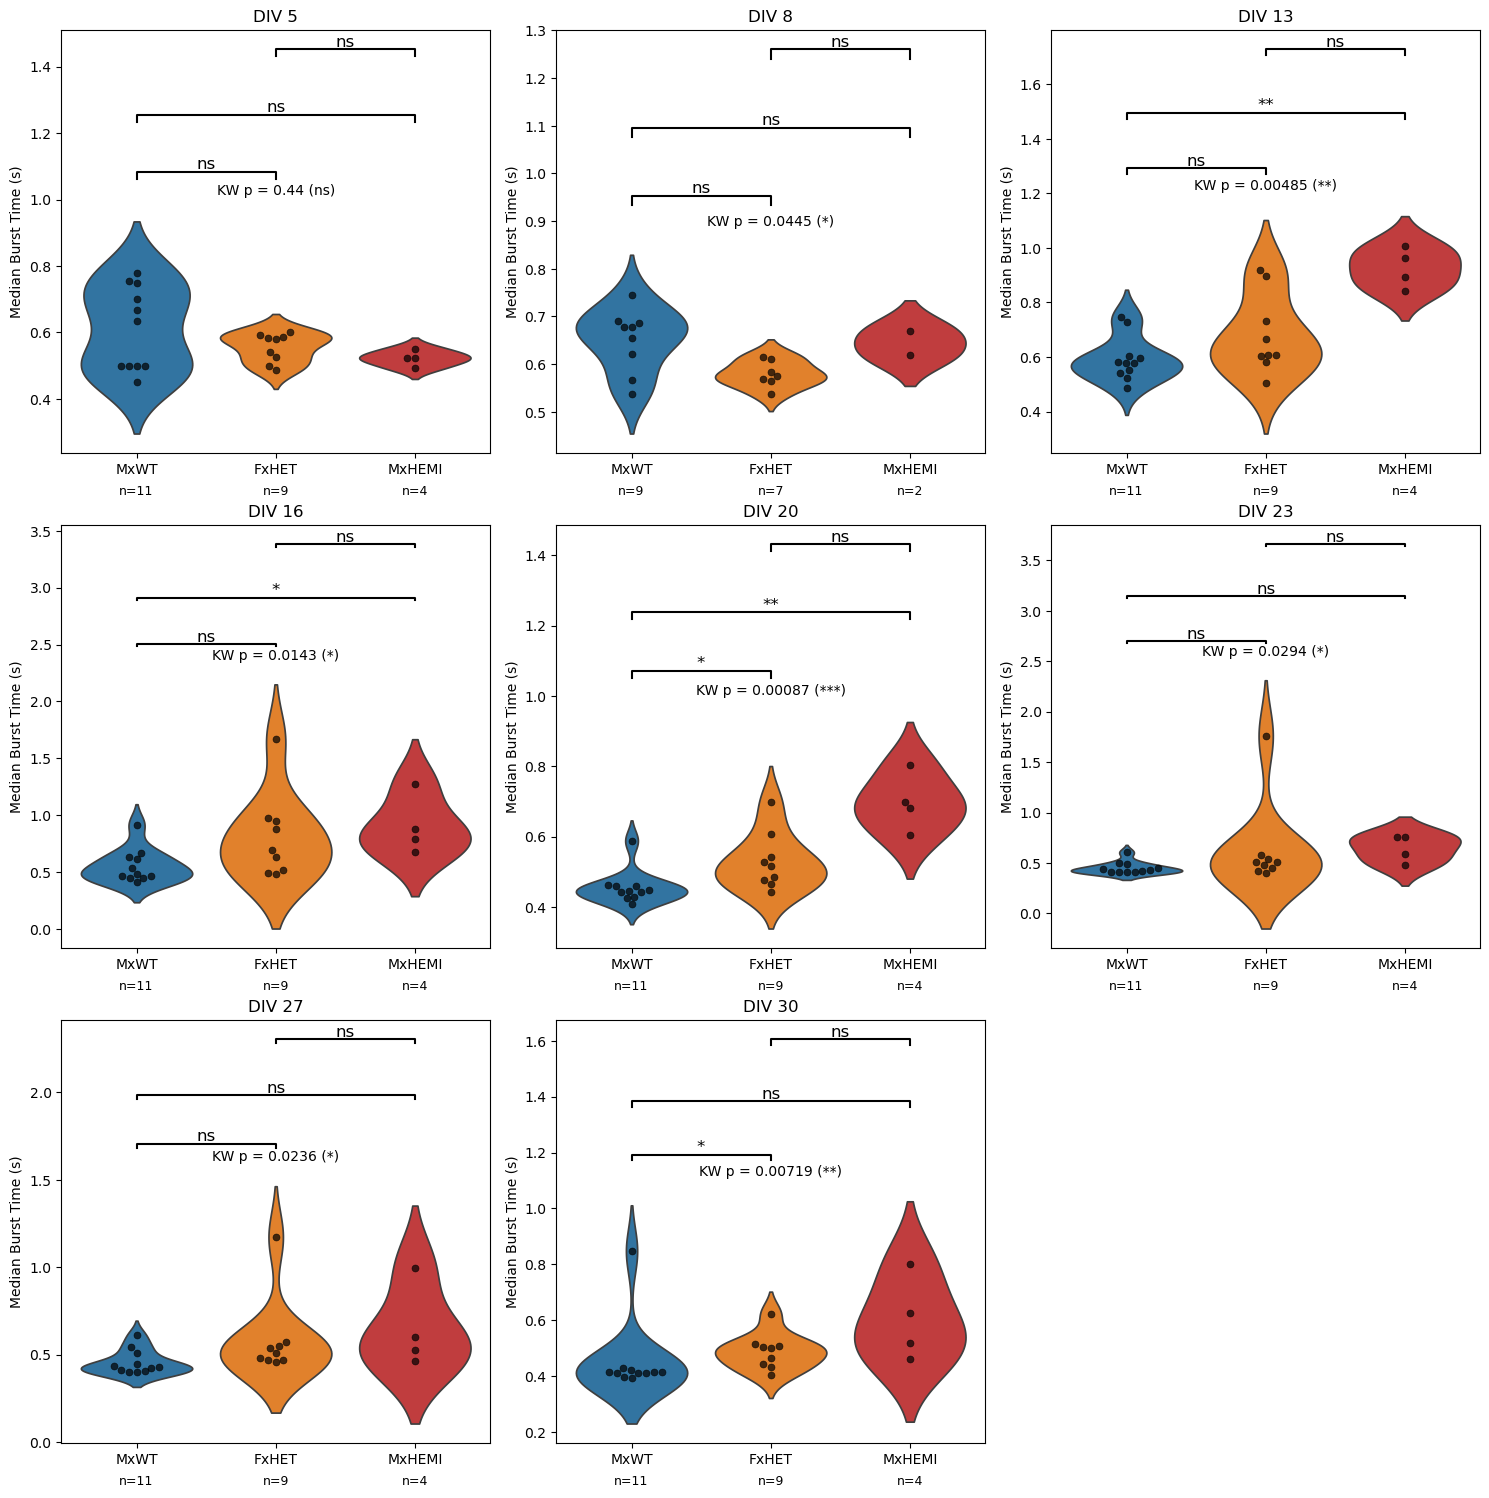

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests

# --- Prepare long form raw burst time data ---
long_df = network_csv[['DIV', 'Well', 'Chip_ID', 'NeuronType', 'Burst_Times_List_Numeric']].copy()
long_df = long_df.rename(columns={'Burst_Times_List_Numeric': 'Burst_Time_List'})
long_df['ChipID_Well'] = long_df['Chip_ID'].astype(str) + '_W' + long_df['Well'].astype(str)

# Explode burst time lists to one row per event
long_df = long_df.explode('Burst_Time_List').reset_index(drop=True)
long_df = long_df.rename(columns={'Burst_Time_List': 'Burst_Time'})
long_df['Burst_Time'] = pd.to_numeric(long_df['Burst_Time'], errors='coerce')
long_df.dropna(subset=['Burst_Time'], inplace=True)

# Aggregate median burst time per ChipID_Well and NeuronType per DIV
agg_df = long_df.groupby(['DIV', 'ChipID_Well', 'NeuronType']).agg(
    median_burst_time=('Burst_Time', 'mean')
).reset_index()

# Plotting parameters
order = ['MxWT', 'FxHET', 'MxHEMI']
palette = {'MxWT': '#1f77b4', 'FxHET': '#ff7f0e', 'MxHEMI': '#d62728'}

# --- Violin + swarm plots faceted by DIV for per-well median burst times ---
n_divs = agg_df['DIV'].nunique()
fig, axes = plt.subplots(nrows=min(3, n_divs), ncols=int(np.ceil(n_divs / 3)), figsize=(15, 5*min(3, n_divs)))
axes = np.atleast_1d(axes).flatten()

for i, div in enumerate(sorted(agg_df['DIV'].unique())):
    ax = axes[i]

    sub = agg_df[agg_df['DIV'] == div]

    # Violin plot
    sns.violinplot(
        data=sub,
        x='NeuronType',
        y='median_burst_time',
        order=order,
        palette=palette,
        inner=None,
        ax=ax
    )

    # Overlay swarmplot for individual medians
    sns.swarmplot(
        data=sub,
        x='NeuronType',
        y='median_burst_time',
        order=order,
        color='k',
        size=5,
        edgecolor='gray',
        linewidth=0.5,
        alpha=0.7,
        ax=ax
    )

    # Kruskal-Wallis test
    grouped = sub.groupby('NeuronType')['median_burst_time']
    groups = [group.values for name, group in grouped]
    if sum(len(g) > 1 for g in groups) >= 2:
        stat, p_kruskal = kruskal(*groups)
    else:
        p_kruskal = np.nan

    # Annotate Kruskal p-value
    if not np.isnan(p_kruskal):
        sig = "***" if p_kruskal < 0.001 else "**" if p_kruskal < 0.01 else "*" if p_kruskal < 0.05 else "ns"
        ax.text(1, ax.get_ylim()[1] * 1.05, f'KW p = {p_kruskal:.3g} ({sig})', ha='center', fontsize=10)

    # Pairwise Mann–Whitney tests with Bonferroni correction
    pairs = list(combinations(order, 2))
    raw_pvals = []
    valid_pairs = []
    for s1, s2 in pairs:
        g1 = sub[sub['NeuronType'] == s1]['median_burst_time']
        g2 = sub[sub['NeuronType'] == s2]['median_burst_time']
        if len(g1) > 1 and len(g2) > 1:
            stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
            raw_pvals.append(p)
            valid_pairs.append((s1, s2))
    if raw_pvals:
        corrected = multipletests(raw_pvals, method='bonferroni')[1]
        for (s1, s2), p_corr in zip(valid_pairs, corrected):
            sig = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else "ns"
            # Add significance lines or text (simple example: text above pairs)
            x1, x2 = order.index(s1), order.index(s2)
            y, h, col = ax.get_ylim()[1] * 1.1, 0.02, 'k'
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1 + x2) * .5, y + h, sig, ha='center', va='bottom', color=col, fontsize=12)

    # Annotate sample sizes
    counts = sub.groupby('NeuronType')['ChipID_Well'].nunique()
    for j, nt in enumerate(order):
        n = counts.get(nt, 0)
        ax.text(j, ax.get_ylim()[0] - (ax.get_ylim()[1]-ax.get_ylim()[0])*0.1, f'n={n}', ha='center', fontsize=9)

    ax.set_title(f'DIV {div}')
    ax.set_xlabel('')
    ax.set_ylabel('Median Burst Time (s)')

# Hide unused axes if any
for ax in axes[len(sorted(agg_df['DIV'].unique())):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/2540944408.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/2540944408.py:46: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/2540944408.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/2540944408.py:46: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.str

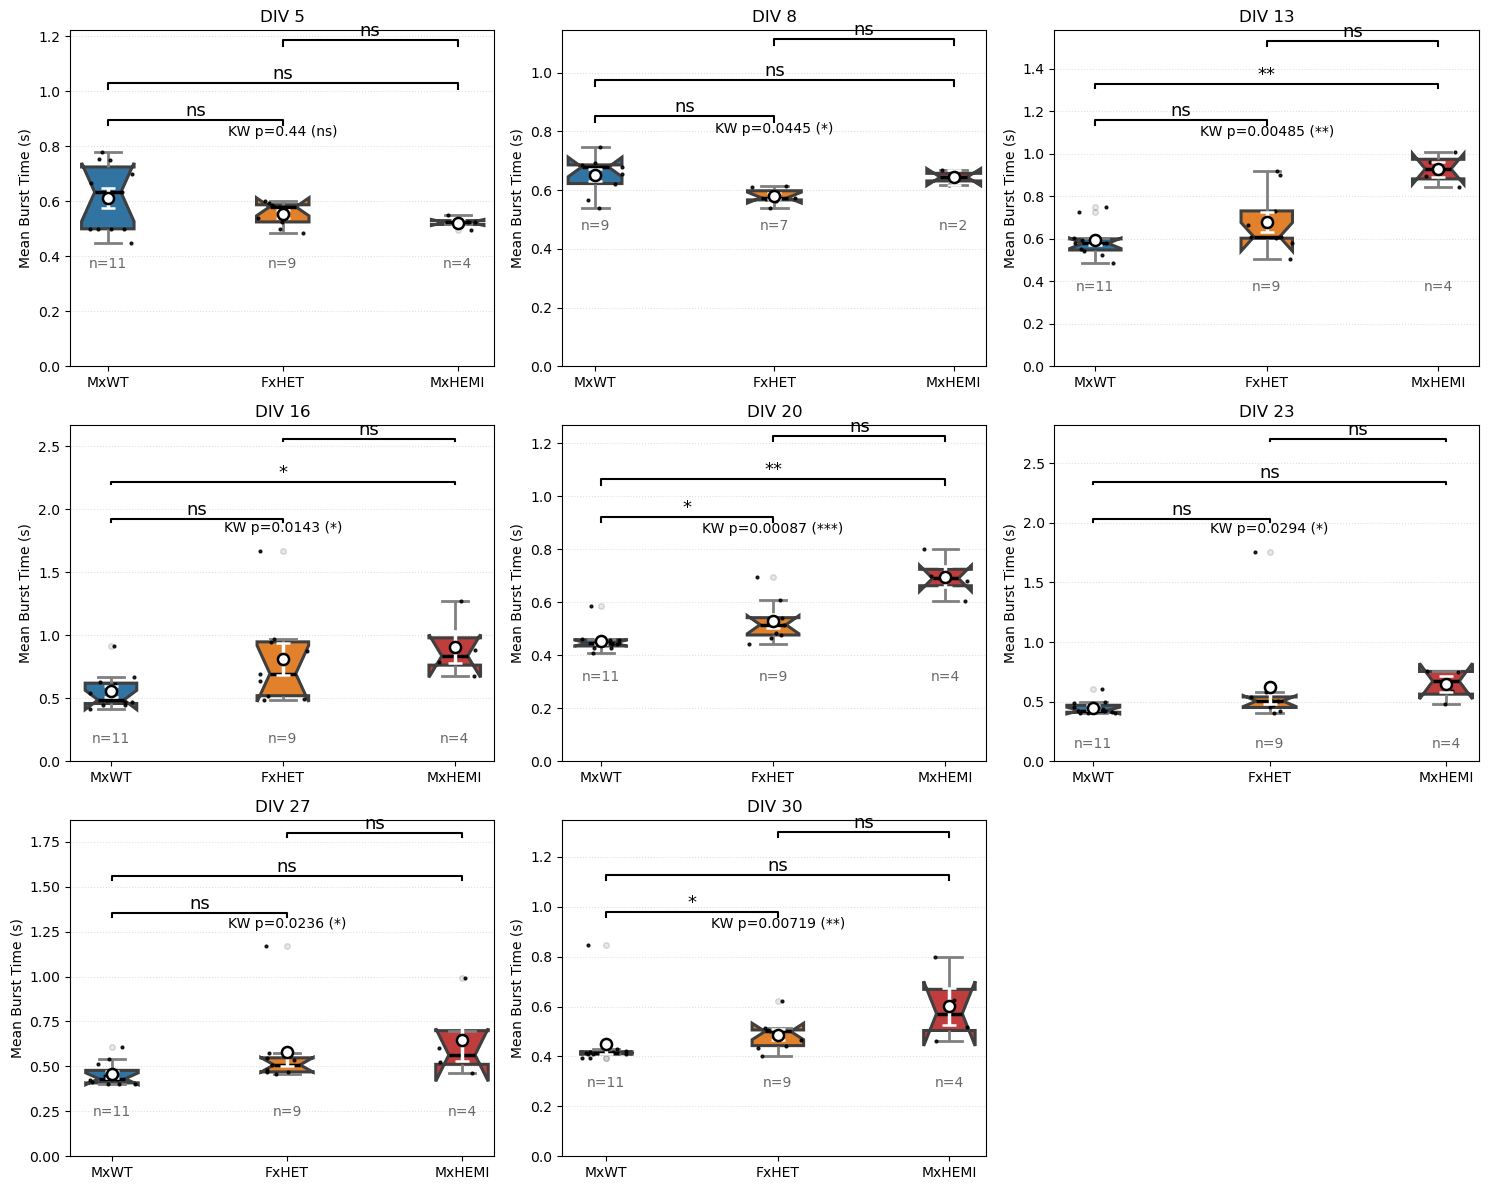

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, kruskal, mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# --- Prepare long form burst time data ---
long_df = network_csv[['DIV', 'Well', 'Chip_ID', 'NeuronType', 'Burst_Times_List_Numeric']].copy()
long_df = long_df.rename(columns={'Burst_Times_List_Numeric': 'Burst_Time_List'})
long_df['ChipID_Well'] = long_df['Chip_ID'].astype(str) + '_W' + long_df['Well'].astype(str)
long_df = long_df.explode('Burst_Time_List').reset_index(drop=True)
long_df = long_df.rename(columns={'Burst_Time_List': 'Burst_Time'})
long_df['Burst_Time'] = pd.to_numeric(long_df['Burst_Time'], errors='coerce')
long_df.dropna(subset=['Burst_Time'], inplace=True)

# Aggregate mean burst time per ChipID_Well and NeuronType per DIV
agg_df = long_df.groupby(['DIV', 'ChipID_Well', 'NeuronType']).agg(
    mean_burst_time=('Burst_Time', 'mean')
).reset_index()

order = ['MxWT', 'FxHET', 'MxHEMI']
palette = {'MxWT': '#1f77b4', 'FxHET': '#ff7f0e', 'MxHEMI': '#d62728'}

n_divs = agg_df['DIV'].nunique()
fig, axes = plt.subplots(nrows=min(3, n_divs), ncols=int(np.ceil(n_divs / 3)), figsize=(15, 4*min(3, n_divs)))
axes = np.atleast_1d(axes).flatten()

for i, div in enumerate(sorted(agg_df['DIV'].unique())):
    ax = axes[i]
    sub = agg_df[agg_df['DIV'] == div]

    # --- Styled boxplot ---
    sns.boxplot(
        data=sub, x='NeuronType', y='mean_burst_time', order=order, 
        palette=palette, showcaps=True, showbox=True, notch=True, width=0.3, linewidth=2.2,
        whiskerprops=dict(linewidth=2, color='gray'),
        capprops=dict(linewidth=2, color='gray'),
        medianprops=dict(linewidth=2.5, color='black'),
        flierprops=dict(marker='o', markersize=4, markerfacecolor='gray', alpha=0.18),
        showfliers=True, ax=ax
    )

    # --- Swarm overlay ---
    sns.stripplot(
    data=sub,
    x='NeuronType',
    y='mean_burst_time',
    order=order,
    color='black',
    size=2,
    alpha=0.85,
    jitter=0.15,   # controls horizontal scatter amount
    edgecolor='gray',
    linewidth=1,
    ax=ax
    )


    # --- Overlay mean ± SEM markers ---
    group_stats = sub.groupby('NeuronType')['mean_burst_time'].agg(['mean', sem])
    for j, nt in enumerate(order):
        if nt in group_stats.index:
            m = group_stats.loc[nt, 'mean']
            e = group_stats.loc[nt, 'sem']
            ax.errorbar(j, m, yerr=e, fmt='o', markersize=8, capsize=5, elinewidth=2.5, markeredgewidth=1.8,
            markerfacecolor='white', markeredgecolor='black', color='white', zorder=15)


    # --- Kruskal-Wallis test ---

    grouped = sub.groupby('NeuronType')['mean_burst_time']
    groups = [group.values for name, group in grouped]
    if sum(len(g) > 1 for g in groups) >= 2:
        stat, p_kruskal = kruskal(*groups)
    else:
        p_kruskal = np.nan
    if not np.isnan(p_kruskal):
        sig = "***" if p_kruskal < 0.001 else "**" if p_kruskal < 0.01 else "*" if p_kruskal < 0.05 else "ns"
        ax.text(1, ax.get_ylim()[1]*1.05, f'KW p={p_kruskal:.3g} ({sig})', ha='center', fontsize=10)

    # --- Pairwise Mann–Whitney U tests with Bonferroni ---
    pairs = list(combinations(order, 2))
    raw_pvals = []
    valid_pairs = []
    for s1, s2 in pairs:
        g1 = sub[sub['NeuronType'] == s1]['mean_burst_time']
        g2 = sub[sub['NeuronType'] == s2]['mean_burst_time']
        if len(g1) > 1 and len(g2) > 1:
            stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
            raw_pvals.append(p)
            valid_pairs.append((s1, s2))
    if raw_pvals:
        corrected = multipletests(raw_pvals, method='bonferroni')[1]
        for (s1, s2), p_corr in zip(valid_pairs, corrected):
            sig = "***" if p_corr < 0.001 else "**" if p_corr < 0.01 else "*" if p_corr < 0.05 else "ns"
            x1, x2 = order.index(s1), order.index(s2)
            y, h, col = ax.get_ylim()[1]*1.1, 0.02, 'k'
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1 + x2) * .5, y + h, sig, ha='center', va='bottom', color=col, fontsize=13)

    # --- Annotate sample sizes ---
    counts = sub.groupby('NeuronType')['ChipID_Well'].nunique()
    for j, nt in enumerate(order):
        n = counts.get(nt, 0)
        ax.text(j, ax.get_ylim()[0] - (ax.get_ylim()[1]-ax.get_ylim()[0])*0.07, f'n={n}', ha='center', fontsize=10, color='dimgrey')

    # --- Gridlines and cosmetics ---
    ax.yaxis.grid(True, linestyle=':', alpha=0.4)
    ax.set_axisbelow(True)
    ax.set_title(f'DIV {div}')
    ax.set_xlabel('')
    ax.set_ylabel('Mean Burst Time (s)')
    ax.set_ylim(bottom=0)

for ax in axes[n_divs:]:
    ax.axis('off')

plt.tight_layout()

plt.show()


/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1199756301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/Users/mandarmp/anaconda3/envs/map/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1199756301.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


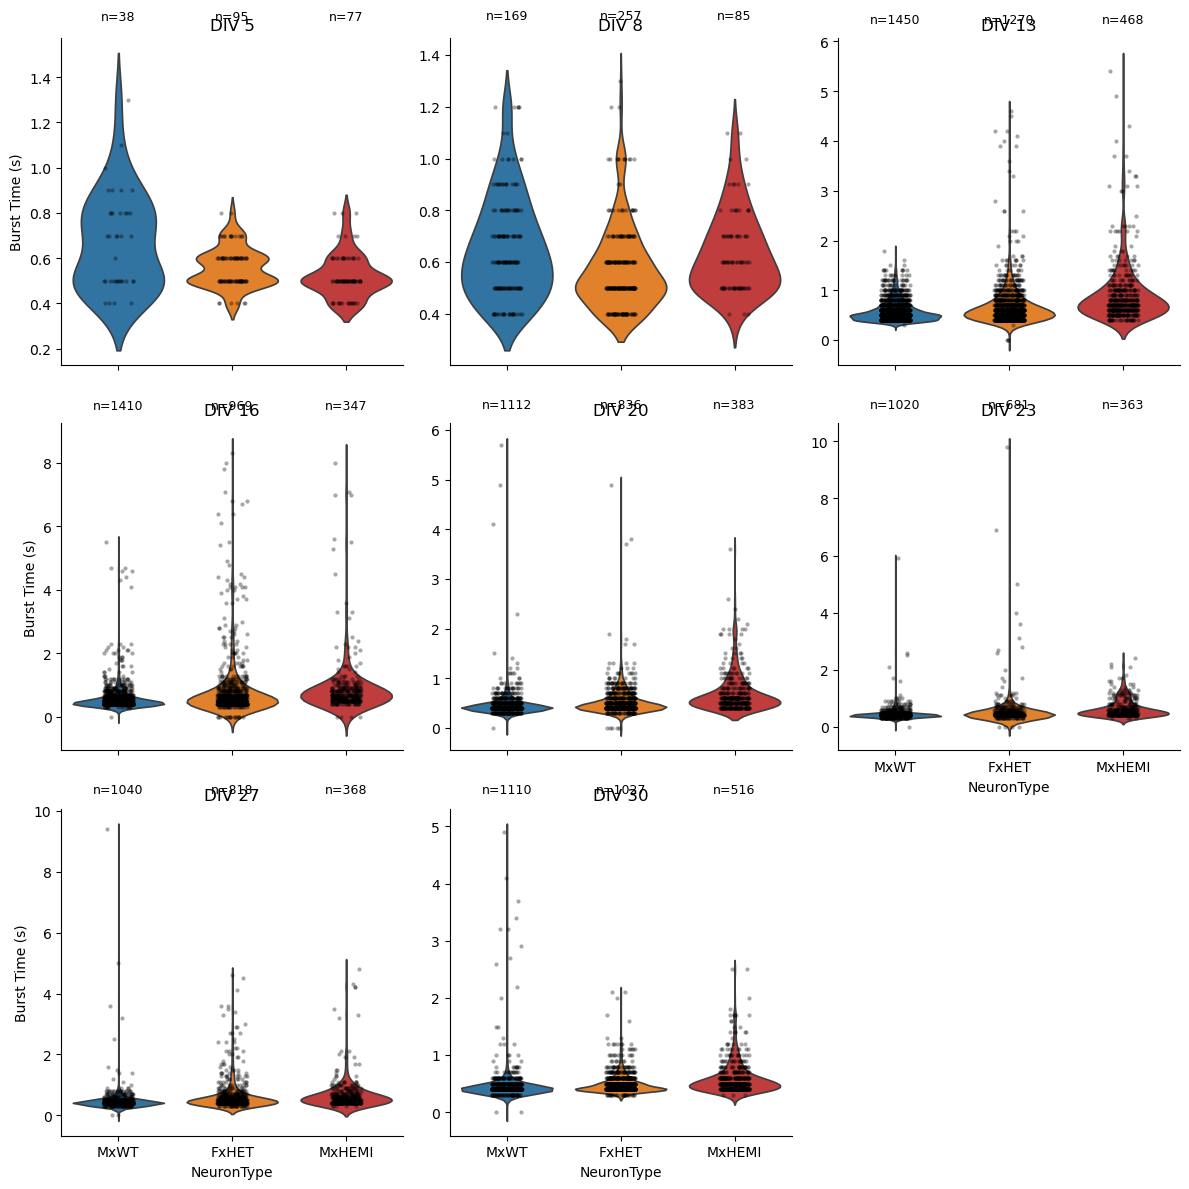

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# (Your seaborn.catplot code for violin and stripplot faceted by DIV as before)

g = sns.catplot(
    data=long_df,
    x='NeuronType',
    y='Burst_Time',
    col='DIV',
    kind='violin',
    order=order,
    palette=palette,
    col_wrap=3,
    height=4,
    sharey=False,
    inner=None
)

for ax, div in zip(g.axes.flat, sorted(long_df['DIV'].unique())):
    sub = long_df[long_df['DIV'] == div]
    sns.stripplot(
        data=sub,
        x='NeuronType',
        y='Burst_Time',
        order=order,
        color='black',
        alpha=0.35,
        size=3,
        jitter=0.13,
        ax=ax
    )
    # Set y-axis to log scale
    #ax.set_yscale('log')
    # Optionally choose nice logticks
    #ax.yaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))
    counts = sub.groupby('NeuronType')['Burst_Time'].count()
    for i, nt in enumerate(order):
        n = counts.get(nt, 0)
        ax.text(i, ax.get_ylim()[1]*1.05, f'n={n}', ha='center', fontsize=9)
    ax.set_title(f'DIV {div}')
    ax.set_xlabel('')

g.set_axis_labels('NeuronType', 'Burst Time (s)')
plt.tight_layout()
plt.show()


/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1597951158.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1597951158.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1597951158.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1597951158.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is dep

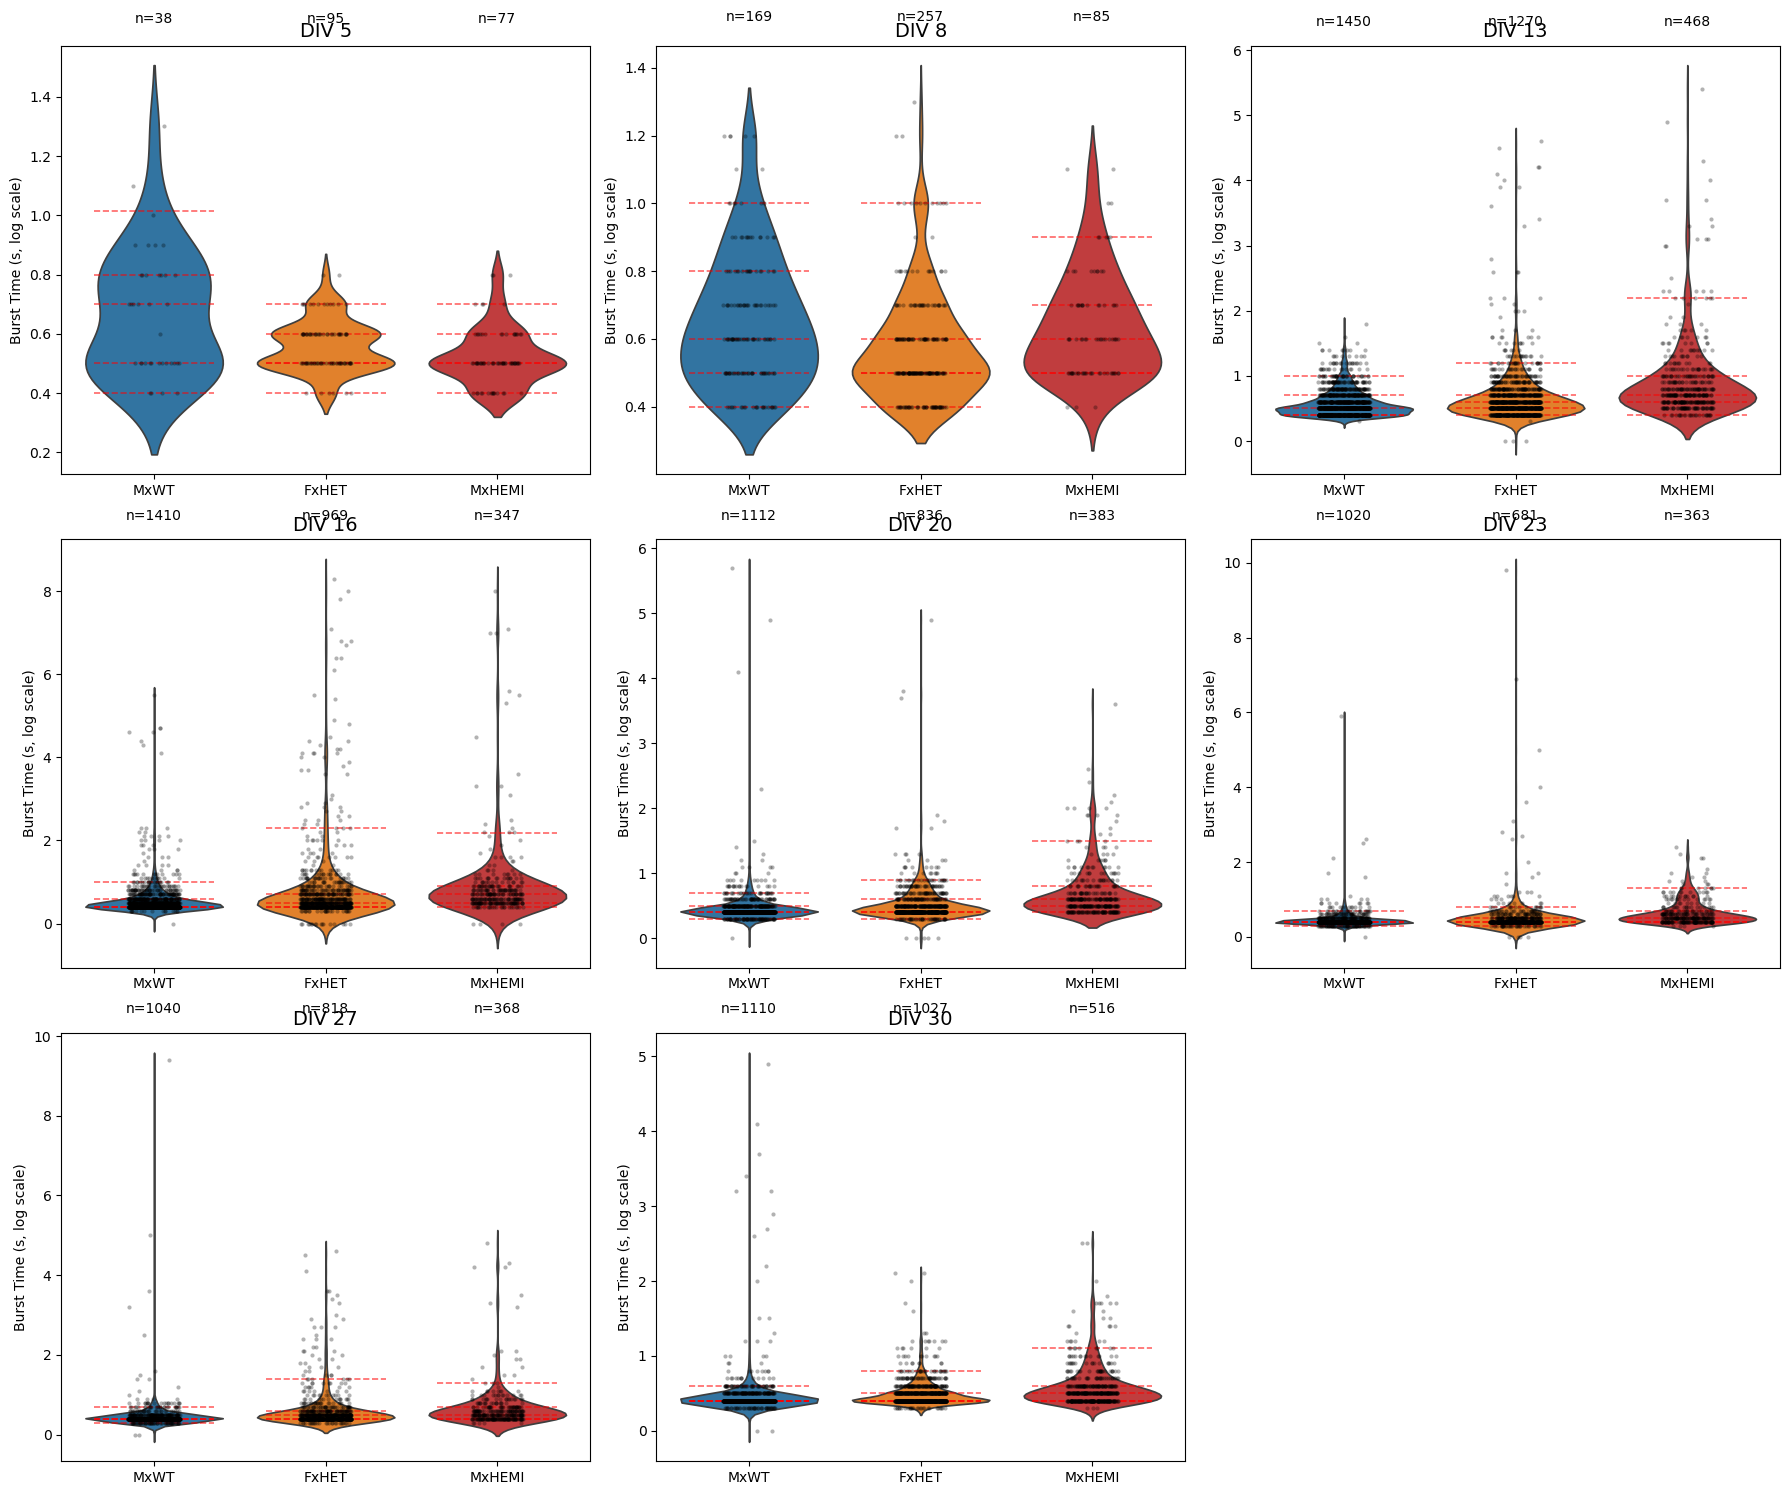

/Users/mandarmp/anaconda3/envs/map/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/6w/yr2wjnwn37lg4ybj5mgstyv40000gn/T/ipykernel_10437/1597951158.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


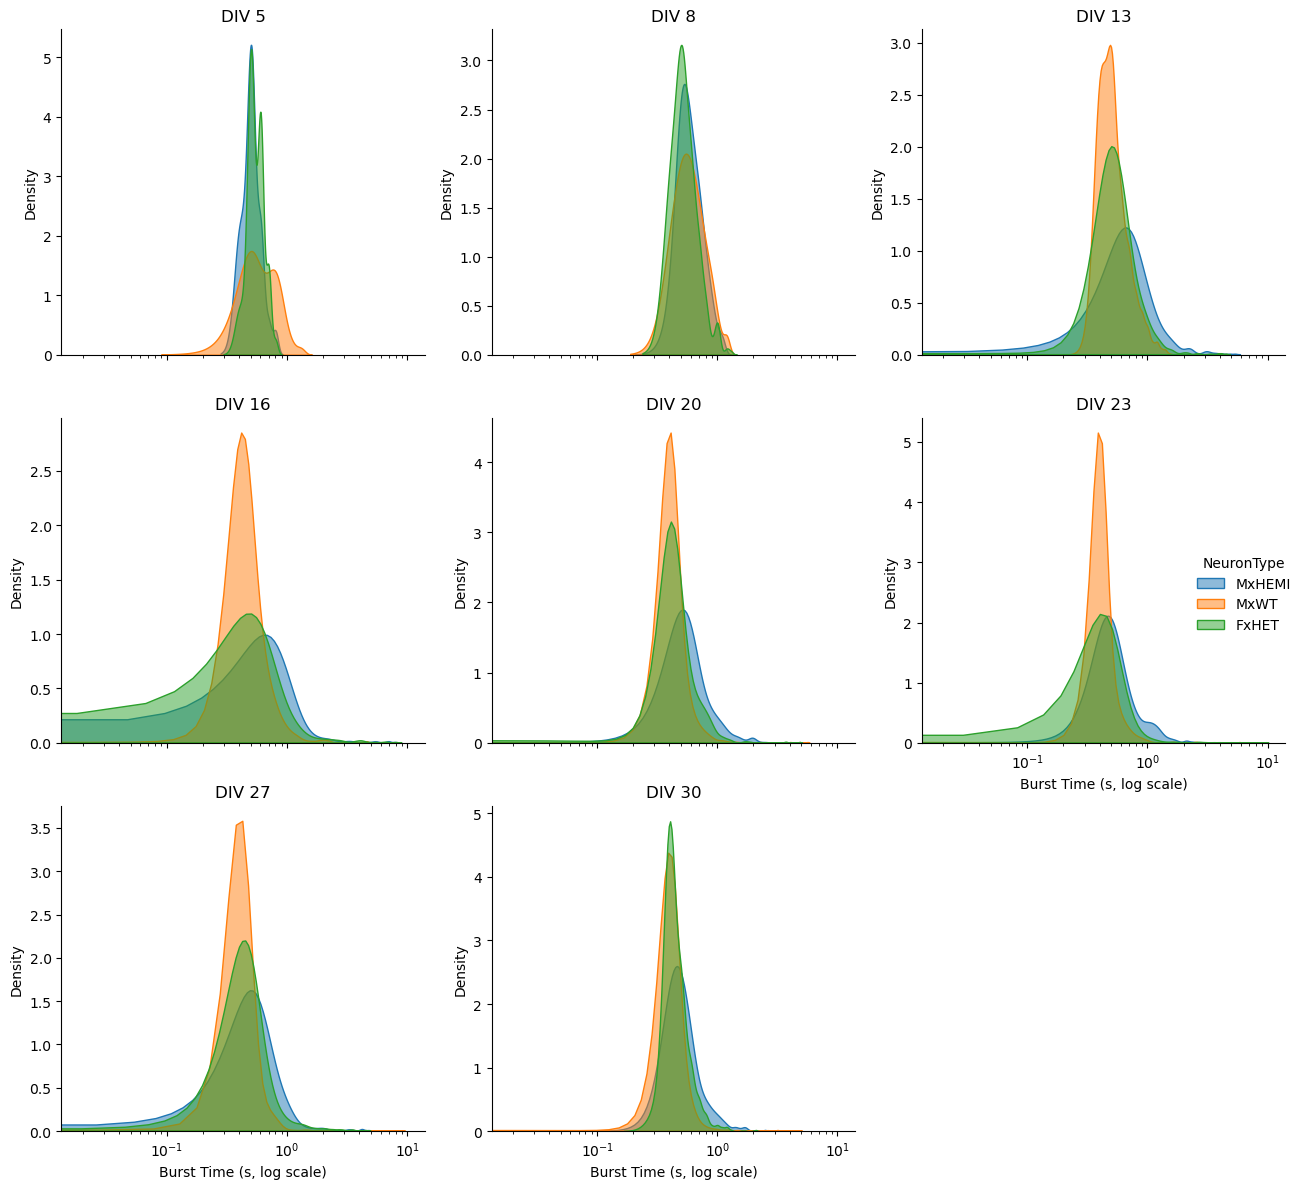

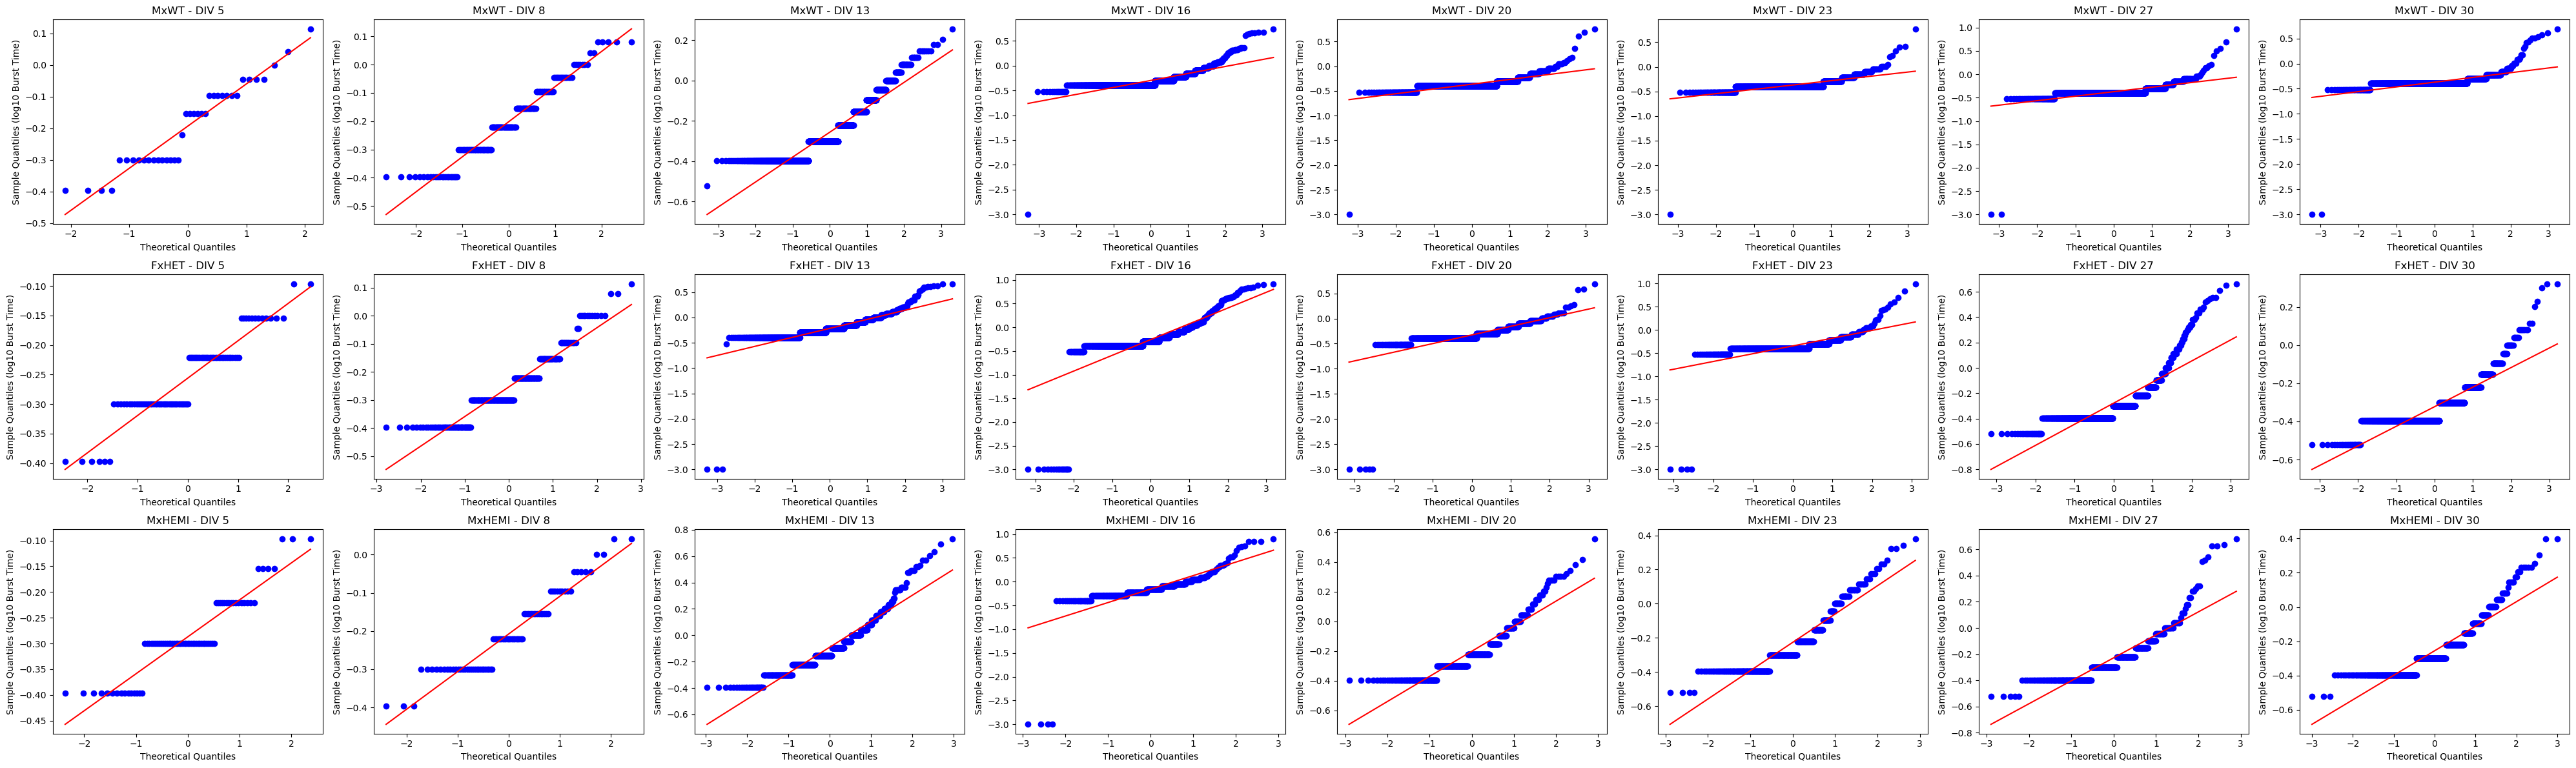

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Prepare the data (assume network_csv is your original DataFrame)
long_df = network_csv[['DIV', 'Well', 'Chip_ID', 'NeuronType', 'Burst_Times_List_Numeric']].copy()
long_df = long_df.rename(columns={'Burst_Times_List_Numeric': 'Burst_Time_List'})
long_df['ChipID_Well'] = long_df['Chip_ID'].astype(str) + '_W' + long_df['Well'].astype(str)

# Explode the burst times lists into one row per burst event
long_df = long_df.explode('Burst_Time_List').reset_index(drop=True)
long_df = long_df.rename(columns={'Burst_Time_List': 'Burst_Time'})
long_df['Burst_Time'] = pd.to_numeric(long_df['Burst_Time'], errors='coerce')
long_df.dropna(subset=['Burst_Time'], inplace=True)

# Parameters
order = ['MxWT', 'FxHET', 'MxHEMI']
palette = {'MxWT': '#1f77b4', 'FxHET': '#ff7f0e', 'MxHEMI': '#d62728'}

# --- Figure 1: Violin plots with raw data points and percentile lines ---

n_divs = len(long_df['DIV'].unique())
fig, axes = plt.subplots(nrows=min(3, n_divs), ncols=(n_divs + 2) // 3, figsize=(18, 5 * min(3, n_divs)))
axes = axes.flatten()

for i, div in enumerate(sorted(long_df['DIV'].unique())):
    ax = axes[i]
    sub = long_df[long_df['DIV'] == div]

    # Violin plot without inner (to overlay percentile lines and points manually)
    sns.violinplot(
        data=sub,
        x='NeuronType',
        y='Burst_Time',
        order=order,
        palette=palette,
        inner=None,
        ax=ax
    )
    # Overlay raw data points (stripplot with jitter and alpha)
    sns.stripplot(
        data=sub,
        x='NeuronType',
        y='Burst_Time',
        order=order,
        color='black',
        size=3,
        jitter=0.15,
        alpha=0.3,
        ax=ax
    )

    # Calculate and plot percentiles per group with thicker horizontal lines
    for j, nt in enumerate(order):
        vals = sub[sub['NeuronType'] == nt]['Burst_Time']
        if len(vals) > 0:
            pcts = np.percentile(vals, [5, 25, 50, 75, 95])
            for pct in pcts:
                ax.hlines(pct, j - 0.35, j + 0.35, colors='red', linewidth=1.2, linestyles='--', alpha=0.6)

    # Log scale on Y axis to compress tails, with handling zero or negative values
    #ax.set_yscale('log')
    #ax.set_ylim(bottom=0.001) 

    ax.set_title(f'DIV {div}', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Burst Time (s, log scale)')

    # Annotate sample size above violins
    group_counts = sub.groupby('NeuronType')['Burst_Time'].count()
    for j, nt in enumerate(order):
        n = group_counts.get(nt, 0)
        ax.text(j, ax.get_ylim()[1]*1.05, f'n={n}', ha='center', fontsize=10)

for ax in axes[n_divs:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# --- Figure 2: Kernel Density Estimate (KDE) plots of burst times by NeuronType and DIV ---

g = sns.FacetGrid(long_df, col='DIV', hue='NeuronType', col_wrap=3, height=4, sharey=False)
g.map(sns.kdeplot, 'Burst_Time', common_norm=False, fill=True, alpha=0.5)
g.add_legend(title='NeuronType')

for ax, div in zip(g.axes.flat, sorted(long_df['DIV'].unique())):
    ax.set_title(f'DIV {div}')
    ax.set_xscale('log')
    ax.set_xlabel('Burst Time (s, log scale)')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

# --- Figure 3: Q-Q Plots of burst time distributions against theoretical normal ---

fig, axes = plt.subplots(len(order), n_divs, figsize=(5 * n_divs, 4 * len(order)), squeeze=False)

for col_i, div in enumerate(sorted(long_df['DIV'].unique())):
    sub_div = long_df[long_df['DIV'] == div]
    for row_i, nt in enumerate(order):
        ax = axes[row_i, col_i]
        data = sub_div[sub_div['NeuronType'] == nt]['Burst_Time'].values
        
        # Log transform data to approach normality for Q-Q plot, add small constant to avoid log(0)
        if len(data) > 0:
            log_data = np.log10(data + 1e-3)
            stats.probplot(log_data, dist="norm", plot=ax)
            ax.set_title(f'{nt} - DIV {div}')
            ax.set_xlabel('Theoretical Quantiles')
            ax.set_ylabel('Sample Quantiles (log10 Burst Time)')
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.axis('off')

plt.tight_layout()
plt.show()
